In [ ]:
import torch
print(f"torch version: {torch.__version__}")
print(f"cuda version: {torch.version.cuda}")

# Maks sure you're using the torch and cuda version
# PyTorch 2.2: ${TORCH}=2.2.0 and ${CUDA}=cpu|cu118|cu121
# PyTorch 2.1: ${TORCH}=2.1.0 and ${CUDA}=cpu|cu118|cu121
# PyTorch 2.0: ${TORCH}=2.0.0 and ${CUDA}=cpu|cu117|cu118

%env TORCH=2.1.0
%env CUDA=cpu

In [ ]:
%pip install -q dgl
# %pip install -q torch_geometric
%pip install -q git+https://github.com/pyg-team/pytorch_geometric.git
# %pip install -q pyg_lib==0.3.1  -f https://data.pyg.org/whl/torch-${TORCH}+${CUDA}.html
%pip install -q pyg_lib torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-${TORCH}+${CUDA}.html

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
import pyg_lib
import torch_geometric

print(f"pyg-lib version: {pyg_lib.__version__}")
print(f"torch-geometric version: {torch_geometric.__version__}")

pyg-lib version: 0.4.0+pt21cpu
torch-geometric version: 2.4.0


In [ ]:
# Standard library imports
import random
import math
import copy
import time

# Data handling, numerical processing, and visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

# Machine learning, neural network modules, and metrics
import torch
import torch.nn as nn
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.nn import Linear, Dropout
from torch.utils.data import Dataset
from torch_geometric.loader import DataLoader
from torch_geometric.data import Data
from torch_geometric.nn import SAGEConv, GCNConv, global_mean_pool
from torch_geometric.datasets import Planetoid, TUDataset
from torch_geometric.loader import NeighborLoader
from torch_geometric.loader import GraphSAINTRandomWalkSampler, GraphSAINTNodeSampler, GraphSAINTEdgeSampler
from torch_geometric.utils import to_networkx
from torch_sparse import SparseTensor
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, euclidean_distances
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

# Graph processing
import networkx as nx

# DGL and datasets
from dgl.data import PPIDataset, CoraGraphDataset

# Set a fixed random seed for reproducibility across multiple libraries
random_seed = 42
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)

# Check for CUDA (GPU support) and set device accordingly
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA is available. Using GPU.")
    torch.cuda.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed)  # For multi-GPU setups
    # Additional settings for ensuring reproducibility on CUDA
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
else:
    device = torch.device("cpu")
    print("CUDA not available. Using CPU.")


CUDA not available. Using CPU.


# Primer on sampling

![img](https://i.ibb.co/fMkhkFF/Screenshot-2024-02-12-at-18-51-34.png)

In [ ]:
def sampler(A, num_samples):
  N = A.size(0)  # Number of nodes
  sampled_neighbors = []

  for i in range(N):
    # Find indices of neighbors (non-zero elements) for node i
    neighbors = torch.nonzero(A[i], as_tuple=False).squeeze(1)
    #####################################################
    ### TODO: sample nodes randomly

    #####################################################
    sampled_neighbors.append(samples.tolist())
  return sampled_neighbors

In [ ]:
adj = torch.tensor([
    [0, 1, 1, 0, 1, 0],
    [1, 0, 1, 0, 0, 0],
    [1, 1, 0, 1, 1, 0],
    [0, 0, 1, 0, 0, 1],
    [1, 0, 1, 0, 0, 0],
    [0, 0, 0, 1, 0, 0],
], dtype=torch.float32, device=device)
labels = torch.tensor([0, 0, 0, 1, 0, 1])

sampler(adj, 4)

[[1, 2, 4], [0, 2], [0, 1, 3, 4], [2, 5], [0, 2], [3]]

In [ ]:
# @title Plot graph utils
def plot_graph(A, lbls, highlight_nodes=[], selected_node=None, ax=None):
  graph = nx.from_numpy_array(A)

  num_labels = np.unique(labels.numpy()).shape[0]
  colormap = cm.get_cmap('viridis', num_labels)
  colors = [colormap(i) for i in range(num_labels)]

  label_color_map = {label:colors[i] for i, label in enumerate(np.unique(lbls))}

  node_colors = [label_color_map[label] for label in lbls]
  # default
  default_node_color = 'lightblue'
  default_node_size = 300
  default_border_width = 1

  # highlight
  highlight_color = 'red'
  highlight_size = 600
  highlight_border_width = 3

  pos = nx.spring_layout(graph, seed=0)
  nx.draw_networkx_nodes(graph, pos,
                        nodelist=[node for node in graph.nodes() if node not in highlight_nodes],
                        node_color=[node_colors[i] for i, node in enumerate(graph.nodes()) if node not in highlight_nodes],
                        node_size=default_node_size,
                        linewidths=default_border_width,
                        edgecolors='black', ax=ax)
  nx.draw_networkx_nodes(graph, pos,
                        nodelist=highlight_nodes,
                        node_color=[node_colors[node] for i, node in enumerate(highlight_nodes)],
                        node_size=highlight_size,
                        linewidths=highlight_border_width,
                        edgecolors='blue', ax=ax)
  nx.draw_networkx_nodes(graph, pos,
                        nodelist=[selected_node] if selected_node is not None else [],
                        node_color=[selected_node] if selected_node is not None else [],
                        node_size=highlight_size,
                        linewidths=highlight_border_width-1,
                        edgecolors='red', ax=ax)
  nx.draw_networkx_edges(graph, pos, ax=ax)
  nx.draw_networkx_labels(graph, pos, ax=ax)

<ipython-input-35-b1aa9c58f4e9>:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap('viridis', num_labels)


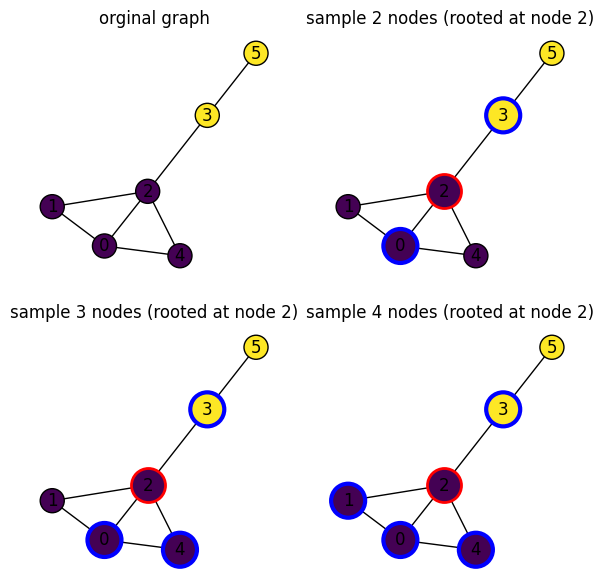

In [ ]:
# @title plot graph
selected_node = 2 # @param {type:"integer"}

fig = plt.figure(figsize=(7, 7))

# orginal graph
ax = fig.add_subplot(2, 2, 1)
ax.axis('off')
ax.set_title("orginal graph")
plot_graph(adj.cpu().numpy(), labels.numpy(), ax=ax)

# sampling neighbours
for i in range(2, 5):
  nodes = sampler(adj, num_samples=i)
  ax = fig.add_subplot(2, 2, i)
  ax.axis('off')
  ax.set_title(f"sample {i} nodes (rooted at node {selected_node})")
  plot_graph(adj.cpu().numpy(), labels.numpy(),
             highlight_nodes=nodes[selected_node],
             selected_node=selected_node,
             ax=ax)

plt.show()

![img](https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSt85ut3Pc21CJw8IZPDKJwlKe8Zw9W3u9K9FLYdo7Cjg&s)

In [ ]:
def random_walk(adj, start_node, walk_length):
  # Ensure the adjacency matrix is a square matrix
  assert adj.size(0) == adj.size(1), "Adjacency matrix must be square."

  num_nodes = adj.size(0)
  walk = [start_node]

  current_node = start_node
  for _ in range(walk_length):
    neighbors = adj[current_node].nonzero().view(-1)
    if len(neighbors) == 0:
        break  # If the current node has no neighbors, stop the walk
    #####################################################
    ### TODO: sample next walk (see torch.randint)

    #####################################################
    walk.append(next_node)
    current_node = next_node

  return walk

In [ ]:
random_walk(adj, 2, 2)

[2, 3, 5]

<ipython-input-7-b1aa9c58f4e9>:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap('viridis', num_labels)


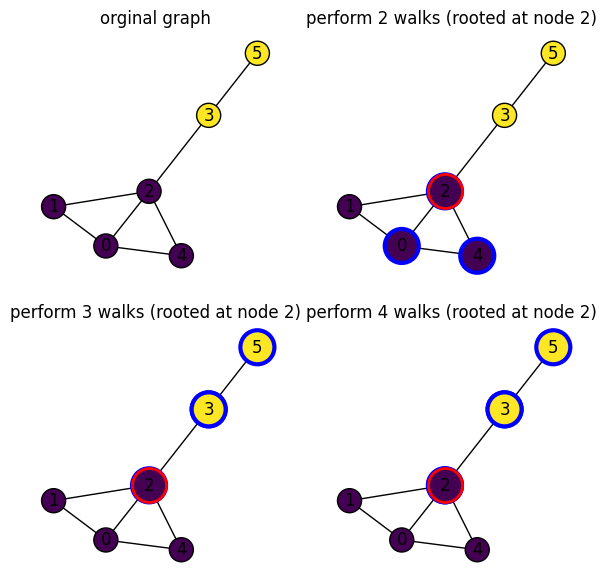

In [ ]:
# @title plot graph
start_node = 2 # @param {type:"integer"}
walk_length = 2 # @param {type:"integer"}

fig = plt.figure(figsize=(7, 7))

# orginal graph
ax = fig.add_subplot(2, 2, 1)
ax.axis('off')
ax.set_title("orginal graph")
plot_graph(adj.cpu().numpy(), labels.numpy(), ax=ax)

# sampling neighbours
for i in range(2, 5):
  nodes = random_walk(adj, start_node, i)
  ax = fig.add_subplot(2, 2, i)
  ax.axis('off')
  ax.set_title(f"perform {i} walks (rooted at node {start_node})")
  plot_graph(adj.cpu().numpy(), labels.numpy(),
             highlight_nodes=nodes,
             selected_node=start_node,
             ax=ax)

plt.show()

# Sampling

The PubMed dataset is used for node classification tasks.

The dataset comprises scientific publications as nodes and citations between these publications as edges, forming a graph structure.

In [ ]:
dataset = Planetoid(root='.', name="Pubmed")
data = dataset[0]

# Print information about the dataset
print(f'Dataset: {dataset}')
print('-------------------')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of nodes: {data.x.shape[0]}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

# Print information about the graph
print(f'\nGraph:')
print('------')
print(f'Training nodes: {sum(data.train_mask).item()}')
print(f'Evaluation nodes: {sum(data.val_mask).item()}')
print(f'Test nodes: {sum(data.test_mask).item()}')
print(f'Edges are directed: {data.is_directed()}')
print(f'Graph has isolated nodes: {data.has_isolated_nodes()}')
print(f'Graph has loops: {data.has_self_loops()}')

Dataset: Pubmed()
-------------------
Number of graphs: 1
Number of nodes: 19717
Number of features: 500
Number of classes: 3

Graph:
------
Training nodes: 60
Evaluation nodes: 500
Test nodes: 1000
Edges are directed: False
Graph has isolated nodes: False
Graph has loops: False


In [ ]:
def plot_subgraph_batch(subgraph, title=""):
  subgraph_nx = to_networkx(subgraph, to_undirected=True)

  fig = plt.figure(figsize=(4,4))
  nx.draw_networkx(subgraph_nx,
        pos=nx.spring_layout(subgraph_nx, seed=10), with_labels=True,
        node_size=150, node_color=subgraph.y, cmap="cool", font_size=10
      )
  plt.title(title)
  plt.axis('off')
  plt.show()

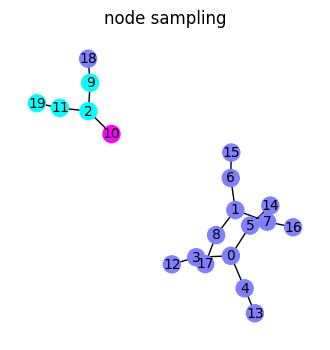

In [ ]:
# display a subgraph
sage_sampler = NeighborLoader(
    data=data,
    num_neighbors=[3, 1],
    batch_size=3,
    input_nodes=data.train_mask,
)

subgraph_sage_sampler = next(iter(sage_sampler))
plot_subgraph_batch(subgraph_sage_sampler, title="node sampling")


GraphSAINT (Graph Sampling Based Inductive Learning Method) is a novel graph neural network (GNN) training framework designed to efficiently handle large graphs.

**Advantages:**
- Full-Graph Training Limitations
- Minibatch Training Issues

**Graph Sampling:** GraphSAINT introduces several graph sampling techniques (node sampling, edge sampling, and random walk sampling) to generate smaller subgraphs for training. These sampling methods are designed to preserve the structural properties of the original graph, ensuring that the sampled subgraphs are representative.

[![Screenshot-2024-02-12-at-18-10-44.png](https://i.postimg.cc/xdMHt3FP/Screenshot-2024-02-12-at-18-10-44.png)](https://postimg.cc/Jy7GhZ8y)

**Normalization and Scaling:** To address the bias introduced by sampling, GraphSAINT proposes a normalization scheme that scales the loss and gradient for each sampled subgraph according to its sampling probability. This normalization ensures unbiased gradient estimates, leading to more effective and stable training.

**Inductive Learning:** GraphSAINT is an inductive learning method, meaning it can generalize to unseen nodes and graphs.

[![Screenshot-2024-02-12-at-18-10-57.png](https://i.postimg.cc/mkDvGwqv/Screenshot-2024-02-12-at-18-10-57.png)](https://postimg.cc/47DL6zXP)

Zeng, Hanqing, et al. "[Graphsaint: Graph sampling based inductive learning method.](https://arxiv.org/pdf/1907.04931.pdf)" arXiv preprint arXiv:1907.04931 (2019).

In [ ]:
# @title pre-compute subgraphs
def pre_load():
  # compute once to pre-load sampled subgraphs in local dir
  GraphSAINTRandomWalkSampler(data, batch_size=3000, walk_length=2,
                                     num_steps=5, sample_coverage=100,
                                     save_dir=dataset.processed_dir,
                                     log=False, num_workers=4)
pre_load()

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


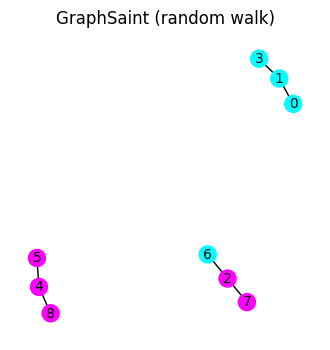

In [ ]:
# display a subgraph
saint_walker_sampler = GraphSAINTRandomWalkSampler(data, batch_size=3, walk_length=2,
                                     num_steps=5, sample_coverage=100,
                                     save_dir=dataset.processed_dir,
                                     log=False, num_workers=4)
subgraph_saint_walker_sampler = next(iter(saint_walker_sampler))
plot_subgraph_batch(subgraph_saint_walker_sampler, title="GraphSaint (random walk)")

FastGCN introduces an efficient training method based on importance sampling, which significantly reduces the computational complexity and memory requirements. The key components of FastGCN include:

- **Importance Sampling:** FastGCN proposes a layer-wise importance sampling technique that selects a subset of nodes for the convolution operation at each layer independently. By sampling nodes according to their importance scores, FastGCN ensures that the most informative nodes are more likely to be selected for training, reducing the number of computations needed while preserving the model's performance.

- **Layer-wise Independence:** Unlike traditional GCNs, where the computation of each layer depends on the output of the previous layer, FastGCN's sampling strategy allows for independent sampling at each layer.

![img](https://i.ibb.co/qDbw2k2/Screenshot-2024-02-12-at-18-42-00.png)


Chen, Jie, Tengfei Ma, and Cao Xiao. "[Fastgcn: fast learning with graph convolutional networks via importance sampling.](https://arxiv.org/pdf/1801.10247.pdf)" arXiv preprint arXiv:1801.10247 (2018).

In [ ]:
class FastGCNSampler:
    def __init__(self, data, layer_sizes):
        self.data = data
        self.layer_sizes = layer_sizes
        self.device = data.edge_index.device

        # Compute normalization probabilities for nodes
        edge_index = data.edge_index
        num_nodes = data.num_nodes
        row, col = edge_index
        deg = torch_geometric.utils.degree(col, num_nodes)
        self.adj = SparseTensor(
            row=data.edge_index[0], col=data.edge_index[1],
            value=torch.arange(data.num_edges, device=self.device),
            sparse_sizes=(num_nodes, num_nodes))

        self.probs = deg / deg.sum()

    def sample(self, batch_nodes):
        supports = []
        sampled_nodes = batch_nodes
        for size in self.layer_sizes:
            support, sampled = self._sample_layer(sampled_nodes, size)
            supports.append(support)
            sampled_nodes = sampled
        features = self.data.x[sampled].to(self.device)
        return Data(x=features, edge_indices=supports[::-1], y=self.data.y[sampled],
                    train_mask=self.data.train_mask[sampled],
                    val_mask=self.data.val_mask[sampled],
                    test_mask=self.data.test_mask[sampled],
                    )

    def _sample_layer(self, nodes, size):
        # Sample nodes based on probabilities
        support = self.adj[nodes, :]
        neis = support.sum(0).nonzero().squeeze()
        p1 = self.probs[neis]
        p1 = p1 / torch.sum(p1)
        #####################################################
        ### TODO: sample new nodes according with probability p with replacement

        #####################################################
        u_sampled = neis[sampled]
        support = support[:, u_sampled]
        sampled_p1 = p1[sampled]

        row, col, edge_idx = support.coo()
        support = torch.stack([row, col], dim=0)

        # Sample nodes based on probabilities
        # sampled = torch.multinomial(self.probs, num_samples=size, replacement=True)
        # Create subgraph for sampled nodes
        # support = torch_geometric.utils.subgraph(sampled, self.data.edge_index, relabel_nodes=True, num_nodes=self.data.num_nodes)[0]

        return support, sampled

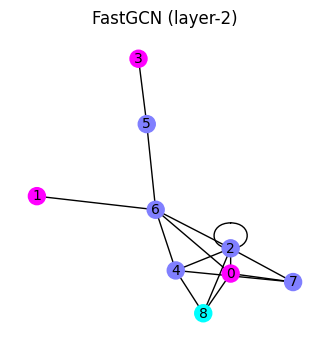

In [ ]:
fastgcn_sampler = FastGCNSampler(data, [7, 9])
subgraph_fastgcn_sampler = fastgcn_sampler.sample([0, 4])

subgraph_fastgcn_sampler.edge_index = subgraph_fastgcn_sampler.edge_indices[0]
plot_subgraph_batch(subgraph_fastgcn_sampler, title="FastGCN (layer-2)")

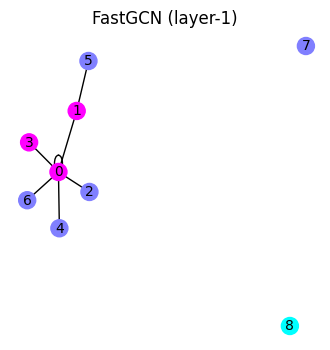

In [ ]:
subgraph_fastgcn_sampler.edge_index = subgraph_fastgcn_sampler.edge_indices[1]
plot_subgraph_batch(subgraph_fastgcn_sampler, title="FastGCN (layer-1)")

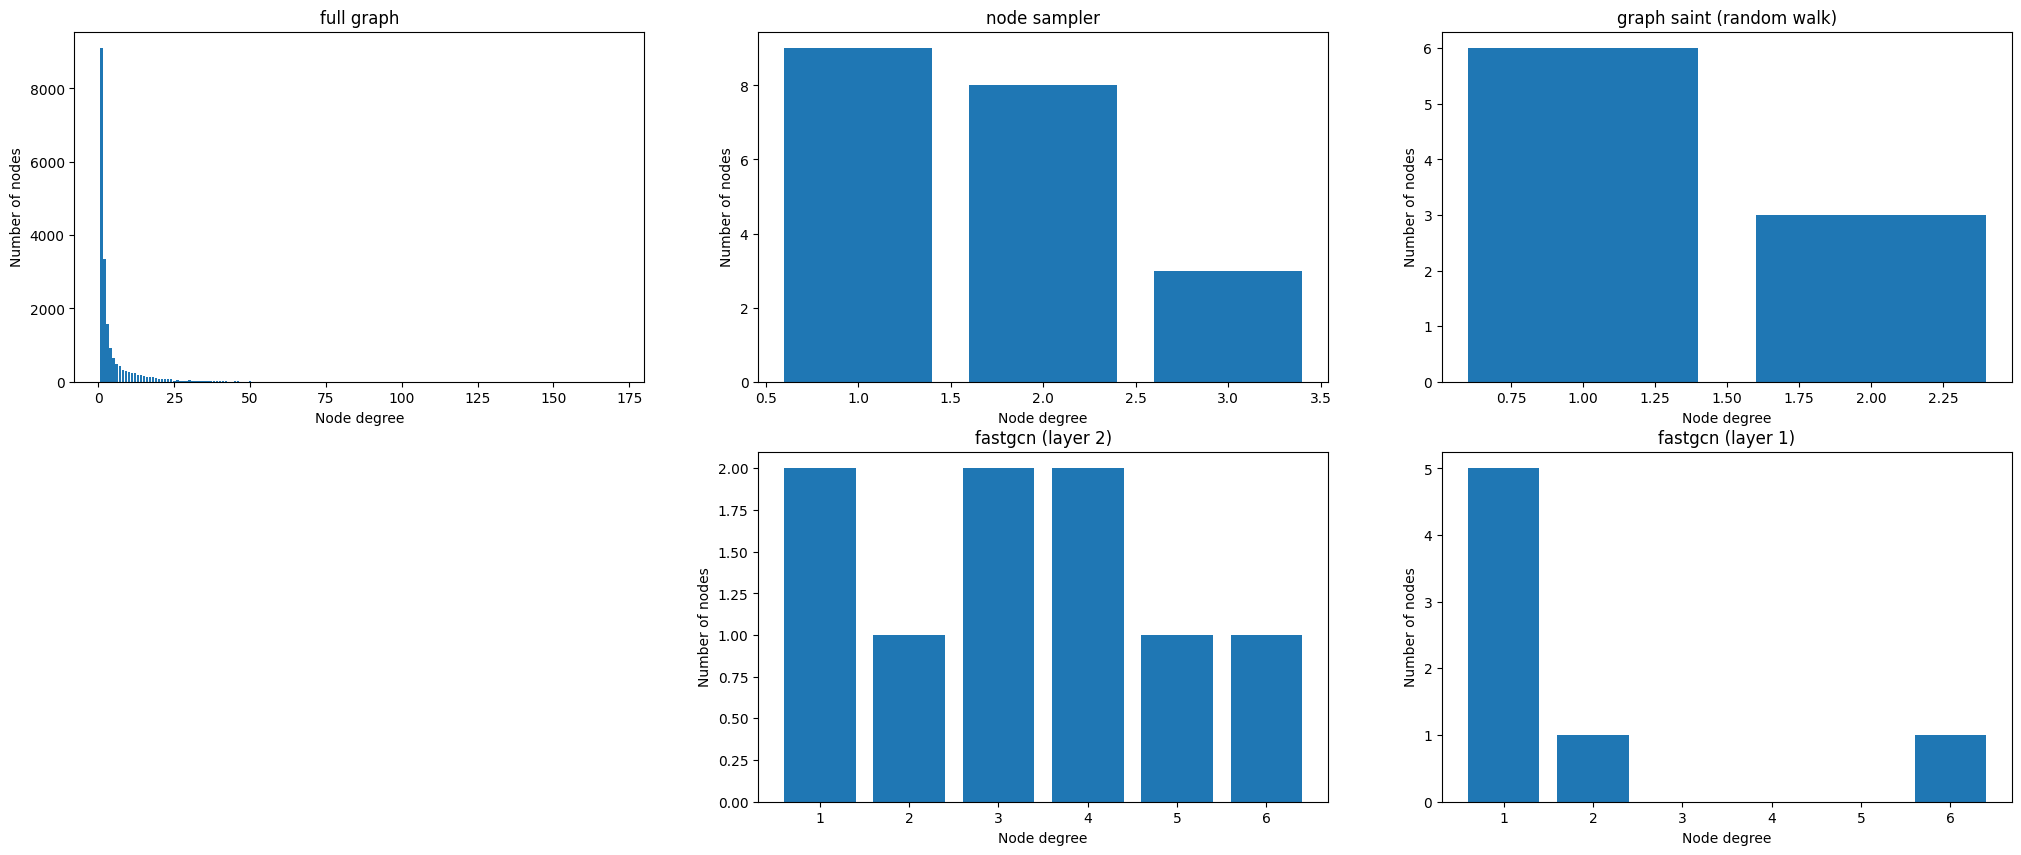

In [ ]:
from torch_geometric.utils import degree, to_undirected
from collections import Counter

def plot_degree(data, ax=ax, title=""):
  edge_index = to_undirected(data.edge_index)
  degrees = degree(edge_index[0]).numpy()
  numbers = Counter(degrees)
  degrees = list(map(int, numbers.keys()))
  ax.set_title(title)
  ax.set_xlabel('Node degree')
  ax.set_ylabel('Number of nodes')
  ax.bar(degrees, numbers.values())

fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(25, 10))
plot_degree(data, ax=ax1, title="full graph")
plot_degree(subgraph_sage_sampler, ax=ax2, title="node sampler")
plot_degree(subgraph_saint_walker_sampler, ax=ax3, title="graph saint (random walk)")
ax4.set_axis_off()
subgraph_fastgcn_sampler.edge_index = subgraph_fastgcn_sampler.edge_indices[0]
plot_degree(subgraph_fastgcn_sampler, ax=ax5, title="fastgcn (layer 2)")
subgraph_fastgcn_sampler.edge_index = subgraph_fastgcn_sampler.edge_indices[1]
plot_degree(subgraph_fastgcn_sampler, ax=ax6, title="fastgcn (layer 1)")

## Utility functions

In [ ]:
def get_batches(train_ind, batch_size=64, shuffle=True):
    nums = train_ind.shape[0]
    if shuffle:
        np.random.shuffle(train_ind)
    i = 0
    while i < nums:
        cur_ind = train_ind[i:i + batch_size]
        yield cur_ind
        i += batch_size

In [ ]:
def train_step(model, data , optimizer, criterion, model_type=""):
  model.train()
  optimizer.zero_grad()
  if model_type == "fastgcn":
    out, _ = model(data.x, data.edge_indices)
  else:
    out, _ = model(data.x, data.edge_index)
  loss = criterion(out[data.train_mask], data.y[data.train_mask])
  loss.backward()
  optimizer.step()

  return loss.item(), out

def train(model, loader, epochs, lr, num_edges=0, model_type="", log_loss=False):
  t = time.time()
  optimizer = torch.optim.Adam(model.parameters(),
                            lr=lr, weight_decay=5e-4)
  # criterion = torch.nn.CrossEntropyLoss()
  criterion = F.nll_loss

  best_model = None
  best_valid_acc = 0

  losses = []
  for epoch in range(1, 1 + epochs):
    train_loss = train_acc = valid_loss = valid_acc = 0
    num_iters = 0
    if model_type == "fastgcn":
      iterator_ = get_batches(np.arange(num_edges))
    else:
      iterator_ = loader
    for batch in iterator_:
      if model_type == "fastgcn":
        batch = loader.sample(batch)
      batch = batch.to(device)
      if batch.train_mask.sum() <= 0 or batch.y[batch.val_mask].sum() <= 0:
        continue
      loss, out = train_step(model, batch, optimizer, criterion, model_type)
      train_loss += loss
      train_acc += accuracy(batch.y[batch.train_mask],
                            out[batch.train_mask].argmax(dim=1))

      valid_loss += criterion(out[batch.val_mask], batch.y[batch.val_mask])
      valid_acc += accuracy(batch.y[batch.val_mask],
                            out[batch.val_mask].argmax(dim=1))
      num_iters += 1
    train_loss /= num_iters
    train_acc /= num_iters
    valid_loss /= num_iters
    valid_acc /= num_iters

    if log_loss:
      losses.append(train_loss)
    if valid_acc > best_valid_acc:
        best_valid_acc = valid_acc
        best_model = copy.deepcopy(model)
    if(epoch % 10 == 0):
      print(f'Epoch: {epoch:02d}, '
          f'Loss: {train_loss:.4f}, ',
          f'acc_train: {100*train_acc:.4f}%, ',
          f'acc_valid: {100*valid_acc:.4f}%, ',
          f'time: {time.time() - t:.4f}s.')
  print(f'best acc_valid: {100*best_valid_acc:.4f}%')
  if log_loss:
    return best_model, losses
  return best_model

@torch.no_grad()
def test(model, data, metrics={}, model_type=""):
  model.eval()

  # The output of model on all data
  if model_type == "fastgcn":
    logits, _ = model(data.x, [data.edge_index, data.edge_index])
  else:
    logits, _ = model(data.x, data.edge_index)
  preds = logits.argmax(dim=1)

  result = {
        'train': {},
        'val': {},
        'test': {}
      }

  for name, metric in metrics.items():
    result['train'][name] = metric(data.y[data.train_mask], preds[data.train_mask])
    result['val'][name] = metric(data.y[data.val_mask], preds[data.val_mask])
    result['test'][name] = metric(data.y[data.test_mask], preds[data.test_mask])

  return result

In [ ]:
def calculate_specificity(y_true, y_pred, labels):
    specificity_scores = np.zeros(len(labels))
    for i, label in enumerate(labels):
        binary_true = (y_true == label).int()
        binary_pred = (y_pred == label).int()

        tn, fp, fn, tp = confusion_matrix(binary_true, binary_pred).ravel()

        specificity = tn / (tn + fp) if (tn + fp) != 0 else 0
        specificity_scores[i] = specificity

    return np.mean(specificity_scores)

def compute_accuracy(target, prediction):
  correct = (target == prediction).sum().item()
  total = target.size(0)
  accuracy = correct / total
  return accuracy


sensitivity = lambda y_true, y_pred: recall_score(y_true.cpu(), y_pred.cpu(), average='macro')
specificity = lambda y_true, y_pred: calculate_specificity(y_true.cpu(), y_pred.cpu(), labels.unique().cpu())
accuracy = lambda y_true, y_pred: compute_accuracy(y_true, y_pred)

In [ ]:
class GNN(torch.nn.Module):
  def __init__(self, dim_in, dim_h, dim_out):
    super().__init__()
    self.gcn1 = GCNConv(dim_in, dim_h)
    self.gcn2 = GCNConv(dim_h, dim_out)

  def forward(self, x, edge_index):
    h = torch.relu(self.gcn1(x, edge_index))
    h = F.dropout(h, p=0.5, training=self.training)
    h = self.gcn2(h, edge_index)
    return F.log_softmax(h, dim=1), h

## Node Sampling

In [ ]:
node_sampler = NeighborLoader(
    data,
    num_neighbors=[5, 10],
    batch_size=16,
    input_nodes=data.train_mask,
)
gnn_node_sampler = GNN(dataset.num_features, 64, dataset.num_classes)
best_gnn_node_sampler = train(gnn_node_sampler, node_sampler, 50, lr=0.01)

Epoch: 10, Loss: 0.3968,  acc_train: 95.9559%,  acc_valid: 81.6667%,  time: 0.1578s.
Epoch: 20, Loss: 0.1159,  acc_train: 100.0000%,  acc_valid: 81.2963%,  time: 0.2907s.
Epoch: 30, Loss: 0.0603,  acc_train: 100.0000%,  acc_valid: 90.3030%,  time: 0.4189s.
Epoch: 40, Loss: 0.0568,  acc_train: 100.0000%,  acc_valid: 87.5000%,  time: 0.5480s.
Epoch: 50, Loss: 0.1018,  acc_train: 96.1538%,  acc_valid: 75.0649%,  time: 0.6897s.
best acc_valid: 100.0000%


In [ ]:
metrics = {"acc": accuracy, "sensitivity": sensitivity, "specifity": specificity}
results_node_sampling = test(best_gnn_node_sampler, data, metrics)
results_node_sampling

{'train': {'acc': 0.9666666666666667,
  'sensitivity': 0.9666666666666667,
  'specifity': 0.9875},
 'val': {'acc': 0.8,
  'sensitivity': 0.8083669827962906,
  'specifity': 0.9040825285338016},
 'test': {'acc': 0.777,
  'sensitivity': 0.7781881705610519,
  'specifity': 0.8968681181701084}}

## Graph Saint

In [ ]:
saint_walker_sampler = GraphSAINTRandomWalkSampler(data, batch_size=200, walk_length=2,
                                     num_steps=5, sample_coverage=100,
                                     save_dir=dataset.processed_dir,
                                     log=False, num_workers=4)
gnn_rw_sampler = GNN(dataset.num_features, 64, dataset.num_classes)
best_gnn_rw_sampler = train(gnn_rw_sampler, saint_walker_sampler, 100, lr=0.01)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch: 10, Loss: 0.6600,  acc_train: 76.6667%,  acc_valid: 61.0577%,  time: 1.5278s.
Epoch: 20, Loss: 0.2366,  acc_train: 93.3333%,  acc_valid: 70.3105%,  time: 3.4314s.
Epoch: 30, Loss: 0.3538,  acc_train: 89.3333%,  acc_valid: 67.7518%,  time: 4.9589s.
Epoch: 40, Loss: 0.0997,  acc_train: 100.0000%,  acc_valid: 71.5686%,  time: 6.5048s.
Epoch: 50, Loss: 0.0236,  acc_train: 100.0000%,  acc_valid: 72.3529%,  time: 8.0107s.
Epoch: 60, Loss: 0.3935,  acc_train: 81.2500%,  acc_valid: 82.7381%,  time: 9.5093s.
Epoch: 70, Loss: 0.1582,  acc_train: 100.0000%,  acc_valid: 76.3187%,  time: 10.9886s.
Epoch: 80, Loss: 0.0133,  acc_train: 100.0000%,  acc_valid: 83.4375%,  time: 12.4894s.
Epoch: 90, Loss: 0.0473,  acc_train: 100.0000%,  acc_valid: 80.1044%,  time: 14.3743s.
Epoch: 100, Loss: 0.0795,  acc_train: 100.0000%,  acc_valid: 74.3895%,  time: 15.8696s.
best acc_valid: 89.8911%


In [ ]:
metrics = {"acc": accuracy, "sensitivity": sensitivity, "specifity": specificity}
results_graph_saint = test(best_gnn_rw_sampler, data, metrics)
results_graph_saint

{'train': {'acc': 0.9833333333333333,
  'sensitivity': 0.9833333333333334,
  'specifity': 1.0},
 'val': {'acc': 0.784,
  'sensitivity': 0.7895718358715413,
  'specifity': 0.9094478587454882},
 'test': {'acc': 0.794,
  'sensitivity': 0.7837531896853931,
  'specifity': 0.9103897452943865}}

## FastGCN

In [ ]:
class GNN(torch.nn.Module):
  def __init__(self, dim_in, dim_h, dim_out):
    super().__init__()
    self.gcn1 = GCNConv(dim_in, dim_h, normalize=True)
    self.gcn2 = GCNConv(dim_h, dim_out, normalize=True)

  def forward(self, x, edge_index):
    h = torch.relu(self.gcn1(x, edge_index[0]))
    h = F.dropout(h, p=0.5, training=self.training)
    h = self.gcn2(h, edge_index[1])
    return F.log_softmax(h, dim=1), h

In [ ]:
fastgcn_sampler = FastGCNSampler(data, [64, 64])
gnn_fgcn_sampler = GNN(dataset.num_features, 64, dataset.num_classes)
best_gnn_fgcn_sampler = train(gnn_fgcn_sampler, fastgcn_sampler, 100, lr=0.01, num_edges=data.num_nodes, model_type="fastgcn")

Epoch: 10, Loss: 0.7309,  acc_train: 69.9744%,  acc_valid: 39.3930%,  time: 14.3644s.
Epoch: 20, Loss: 0.7217,  acc_train: 70.0960%,  acc_valid: 38.9705%,  time: 26.1124s.
Epoch: 30, Loss: 0.6999,  acc_train: 71.3318%,  acc_valid: 38.6297%,  time: 37.9094s.
Epoch: 40, Loss: 0.7373,  acc_train: 70.5640%,  acc_valid: 38.8130%,  time: 49.8451s.
Epoch: 50, Loss: 0.7070,  acc_train: 70.7510%,  acc_valid: 37.6656%,  time: 62.0853s.
Epoch: 60, Loss: 0.7282,  acc_train: 70.1166%,  acc_valid: 37.1728%,  time: 75.2328s.
Epoch: 70, Loss: 0.7205,  acc_train: 70.9239%,  acc_valid: 39.3192%,  time: 92.6488s.
Epoch: 80, Loss: 0.6948,  acc_train: 71.9755%,  acc_valid: 38.6990%,  time: 104.3822s.
Epoch: 90, Loss: 0.7055,  acc_train: 70.8609%,  acc_valid: 39.4019%,  time: 115.8971s.
Epoch: 100, Loss: 0.7122,  acc_train: 70.7741%,  acc_valid: 37.9501%,  time: 127.4657s.
best acc_valid: 41.3369%


In [ ]:
metrics = {"acc": accuracy, "sensitivity": sensitivity, "specifity": specificity}
results_fastgcn = test(best_gnn_fgcn_sampler, data, metrics, model_type="fastgcn")
results_fastgcn

{'train': {'acc': 0.9833333333333333,
  'sensitivity': 0.9833333333333334,
  'specifity': 1.0},
 'val': {'acc': 0.768,
  'sensitivity': 0.7820836502721628,
  'specifity': 0.863940103404546},
 'test': {'acc': 0.749,
  'sensitivity': 0.7477644274254445,
  'specifity': 0.853049819254581}}

## Plot metrics

In [ ]:
def plot_metrics(metrics, title, phases=['train', 'val', 'test'], names=[]):
    n_phases = len(phases)
    if not names:
      names = [""] * len(metrics)
    # Setting up the subplot grid
    fig, axs = plt.subplots(n_phases, 1, figsize=(15, 5 * n_phases), sharey=False)

    for i, phase in enumerate(phases):
        # Extracting metric names from the first phase of the first metrics set
        metric_names = list(metrics[0][phase].keys())

        # Number of metrics
        n_metrics = len(metric_names)

        # Data for plotting: reshape scores for all models
        scores_all_models = np.array([[metrics[model_idx][phase][metric] for metric in metric_names] for model_idx in range(len(metrics))])

        # Setting the positions for the bars
        pos = np.arange(n_metrics)
        bar_width = 0.35 / len(metrics)  # Adjust bar width based on the number of models

        # Plotting bars for each metric across models
        for model_idx, (scores_model, name) in enumerate(zip(scores_all_models, names)):
            axs[i].bar(pos + model_idx * bar_width, scores_model, bar_width, label=f'{names[model_idx]}')

        # Adding labels and titles
        axs[i].set_ylabel('Score')
        axs[i].set_xlabel('Metrics')
        axs[i].set_title(f'{phase.capitalize()} Phase Metrics')
        axs[i].set_xticks(pos + bar_width / 2 * (len(metrics) - 1))
        axs[i].set_xticklabels(metric_names)
        axs[i].legend()

    # Setting the main title and showing the plot
    plt.suptitle(title)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

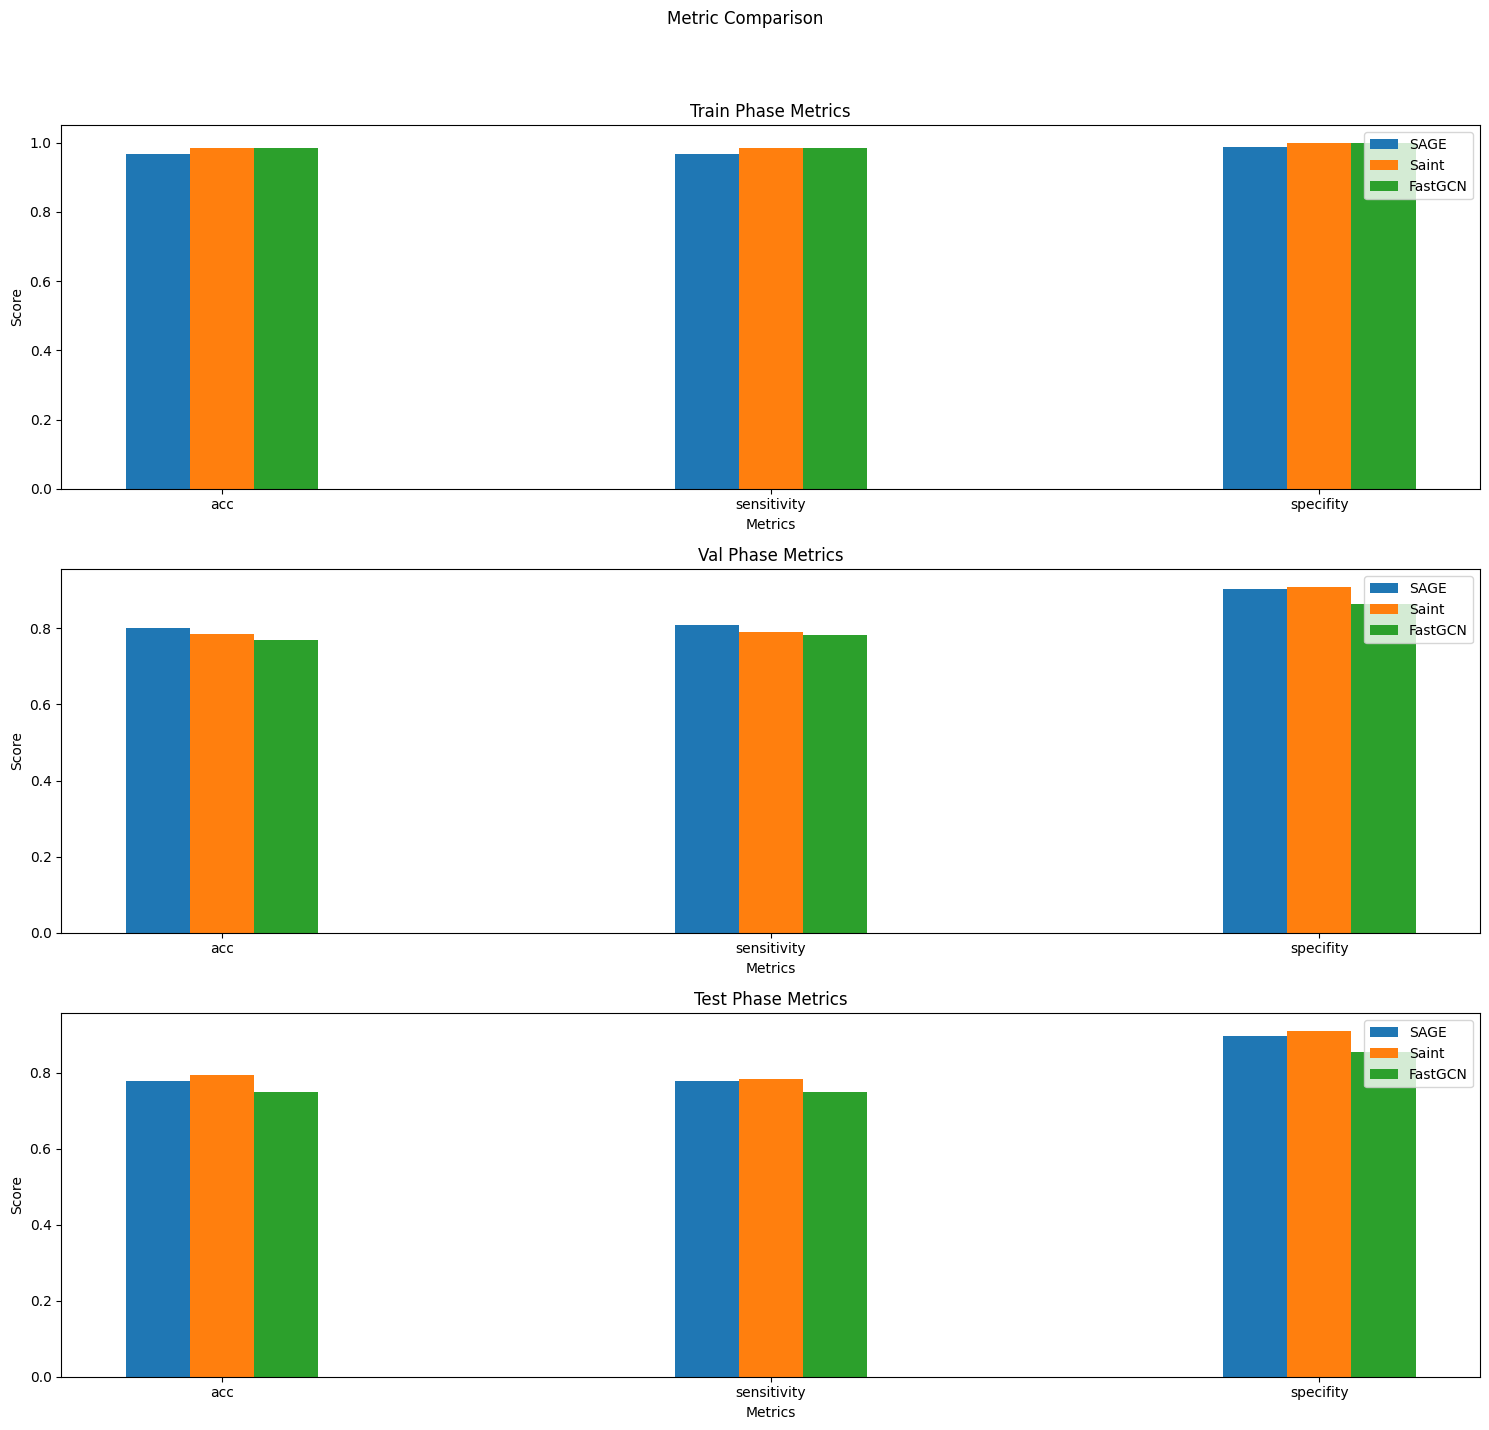

In [ ]:
plot_metrics([
    results_node_sampling,
    results_graph_saint,
    results_fastgcn
    ], 'Metric Comparison', names=["SAGE", "Saint", "FastGCN"])

# Batch Normalization

In [ ]:
def plot_weight_distributions(weights1, weights2, labels, title=""):
    # Flatten the weight matrices
    flattened_weights1 = weights1.flatten()
    flattened_weights2 = weights2.flatten()

    # Create KDE plots
    plt.figure(figsize=(12, 6))
    sns.kdeplot(flattened_weights1, fill=True, color="r", label=labels[0])
    sns.kdeplot(flattened_weights2, fill=True, color="b", label=labels[1])

    plt.title(f"Distribution of GNN Weights {title}")
    plt.xlabel("Weight Value")
    plt.ylabel("Density")
    plt.legend()
    plt.show()

![img](https://i.ibb.co/XCZ6wSC/Screenshot-2024-02-12-at-19-07-11.png)

In [ ]:
class BatchNorm(nn.Module):
    def __init__(self, num_features, eps=1e-5, momentum=0.1):
        super(BatchNorm, self).__init__()
        self.num_features = num_features
        self.eps = eps
        self.momentum = momentum
        # Trainable parameters
        self.gamma = nn.Parameter(torch.ones(num_features))
        self.beta = nn.Parameter(torch.zeros(num_features))
        # Running mean and variance for inference
        # self.register_buffer('running_mean', torch.zeros(num_features))
        # self.register_buffer('running_var', torch.ones(num_features))
        self.training = True

    def forward(self, x):
        if self.training:
            # Calculate mean and variance from input
            batch_mean = torch.mean(x, dim=0)
            batch_var = torch.var(x, dim=0, unbiased=False)

            # Update running mean and variance
            # self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * batch_mean
            # self.running_var = (1 - self.momentum) * self.running_var + self.momentum * batch_var

            # Normalize
            x_normalized = (x - batch_mean) / torch.sqrt(batch_var) + self.eps
        else:
            # Normalize using running mean and variance during inference
            x_normalized = (x - self.running_mean) / torch.sqrt(self.running_var + self.eps)

        #####################################################
        ### TODO: implement Scale and shift

        #####################################################

        return out

In [ ]:
class GNNNoBatchNorm(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GNNNoBatchNorm, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)

        x = self.conv2(x, edge_index)

        return F.log_softmax(x, dim=1), x

class GNNBatchNorm(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GNNBatchNorm, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.bn1 = BatchNorm(hidden_channels)

        self.conv2 = GCNConv(hidden_channels, out_channels)
        self.bn2 = BatchNorm(out_channels)

    def forward(self, x, edge_index):
        x = self.bn1(self.conv1(x, edge_index))
        x = F.relu(x)
        x = F.dropout(x, training=self.training)

        x = self.conv2(x, edge_index)
        x = self.bn2(x)

        return F.log_softmax(x, dim=1), x

In [ ]:
sampler = NeighborLoader(
    data,
    num_neighbors=[5, 10],
    batch_size=300,
    input_nodes=data.train_mask,
)
gnn_no_batchnorm = GNNNoBatchNorm(dataset.num_features, 64, dataset.num_classes)
best_gnn_no_batchnorm, loss_no_batchnorm = train(gnn_no_batchnorm, sampler, 50, lr=0.01, log_loss=True)

Epoch: 10, Loss: 0.6335,  acc_train: 91.6667%,  acc_valid: 82.1429%,  time: 0.0834s.
Epoch: 20, Loss: 0.2670,  acc_train: 96.6667%,  acc_valid: 81.8182%,  time: 0.1434s.
Epoch: 30, Loss: 0.1375,  acc_train: 96.6667%,  acc_valid: 78.2609%,  time: 0.2042s.
Epoch: 40, Loss: 0.0534,  acc_train: 100.0000%,  acc_valid: 89.2857%,  time: 0.2666s.
Epoch: 50, Loss: 0.0476,  acc_train: 100.0000%,  acc_valid: 90.0000%,  time: 0.3353s.
best acc_valid: 96.6667%


In [ ]:
gnn_batchnorm = GNNBatchNorm(dataset.num_features, 64, dataset.num_classes)
best_gnn_batchnorm, loss_batchnorm = train(gnn_batchnorm, sampler, 50, lr=0.01, log_loss=True)

Epoch: 10, Loss: 0.1673,  acc_train: 100.0000%,  acc_valid: 79.3103%,  time: 0.0852s.
Epoch: 20, Loss: 0.0858,  acc_train: 100.0000%,  acc_valid: 80.6452%,  time: 0.1607s.
Epoch: 30, Loss: 0.0365,  acc_train: 100.0000%,  acc_valid: 75.7576%,  time: 0.2411s.
Epoch: 40, Loss: 0.0243,  acc_train: 100.0000%,  acc_valid: 70.3704%,  time: 0.3188s.
Epoch: 50, Loss: 0.0102,  acc_train: 100.0000%,  acc_valid: 76.6667%,  time: 0.3952s.
best acc_valid: 91.3043%


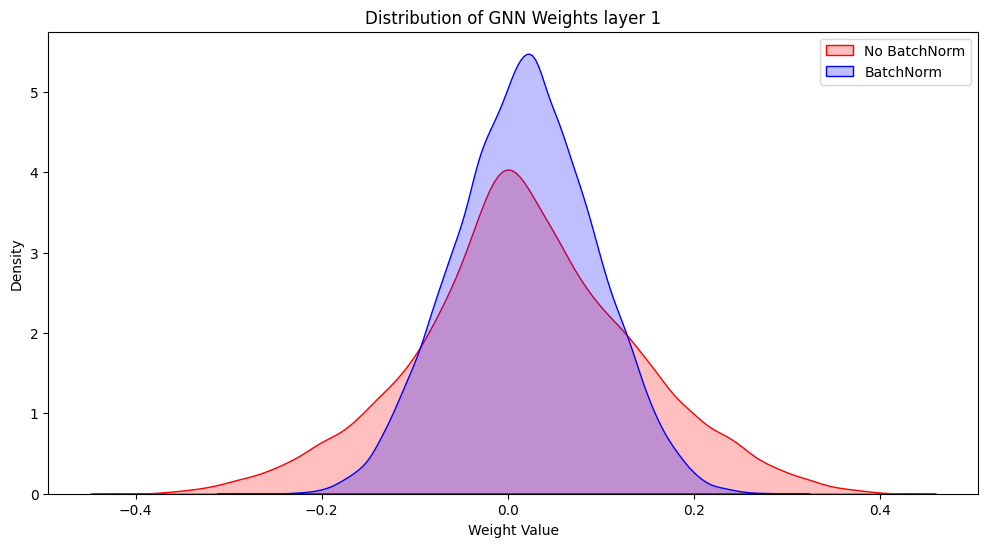

In [ ]:
plot_weight_distributions(
    gnn_no_batchnorm.conv1.lin.weight.detach().cpu().numpy(),
    gnn_batchnorm.conv1.lin.weight.detach().cpu().numpy(),
    labels=["No BatchNorm", "BatchNorm"],
    title="layer 1",
)

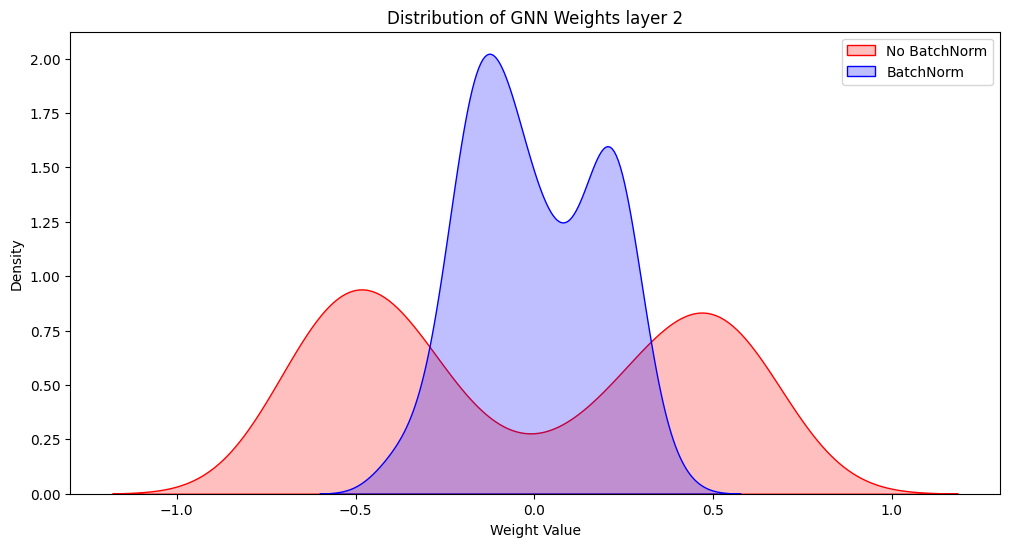

In [ ]:
plot_weight_distributions(
    gnn_no_batchnorm.conv2.lin.weight.detach().cpu().numpy(),
    gnn_batchnorm.conv2.lin.weight.detach().cpu().numpy(),
    labels=["No BatchNorm", "BatchNorm"],
    title="layer 2",
)

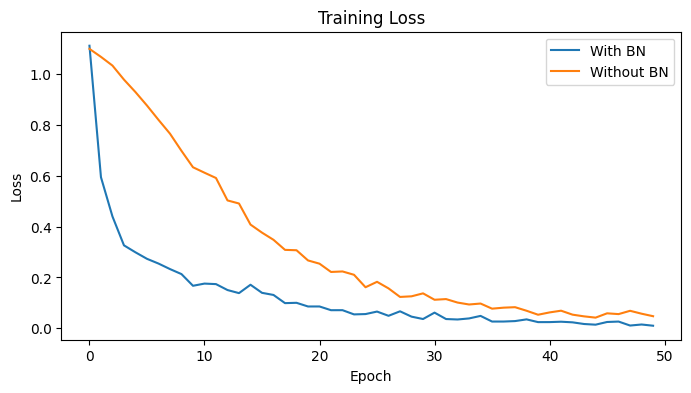

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(loss_batchnorm, label='With BN')
plt.plot(loss_no_batchnorm, label='Without BN')
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Inductive learning

![img](https://i.ibb.co/gdyGdLK/Screenshot-2024-02-12-at-19-23-42.png)

Remember Global mean-pooling from lecture 3.3
$$h_G=\text{Mean}\left(\{h_K^i\in\mathbb{R}^{d_k}, \forall V_G\}\right)$$

In [ ]:
class GNN(torch.nn.Module):
  def __init__(self, in_channels, hidden_channels, out_channels):
    super(GNN, self).__init__()
    self.conv1 = GCNConv(in_channels, hidden_channels)
    self.conv2 = GCNConv(hidden_channels, hidden_channels)
    self.lin = torch.nn.Linear(hidden_channels, out_channels)

  def forward(self, x, edge_index, batch):
    x = F.relu(self.conv1(x, edge_index))
    x = self.conv2(x, edge_index)
    x = global_mean_pool(x, batch)
    x = F.dropout(x, p=0.5, training=self.training)
    x = self.lin(x)
    return F.log_softmax(x, dim=-1)

In [ ]:
dataset = TUDataset(root='/tmp/MUTAG', name='MUTAG')
data = dataset[0]

# Print information about the dataset
print()
print(f'Dataset: {dataset}:')
print('-------------------')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')


print('------')
print(data)
print('------')

# Gather some statistics about the a graph.
print(f'\nGraph:')
print('------')
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')


Dataset: MUTAG(188):
-------------------
Number of graphs: 188
Number of features: 7
Number of classes: 2
------
Data(edge_index=[2, 38], x=[17, 7], edge_attr=[38, 4], y=[1])
------

Graph:
------
Number of nodes: 17
Number of edges: 38
Average node degree: 2.24
Has isolated nodes: False
Has self-loops: False
Is undirected: True


In [ ]:
# Split the dataset into a training set and a test set
train_dataset = dataset[:int(len(dataset) * 0.8)]
test_dataset = dataset[int(len(dataset) * 0.8):]

train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
# Select two graphs
graph1 = dataset[0]
graph2 = dataset[1]

# Convert to NetworkX graphs
G1 = to_networkx(graph1, to_undirected=True)
G2 = to_networkx(graph2, to_undirected=True)

# Plotting
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot graph1
axs[0].set_title('Molecule 1')
nx.draw(G1, ax=axs[0], node_size=20, with_labels=False, node_color='skyblue')

# Plot graph2
axs[1].set_title('Molecule 2')
nx.draw(G2, ax=axs[1], node_size=20, with_labels=False, node_color='lightgreen')

plt.show()

In [ ]:
model = GNN(dataset.num_node_features, 64, dataset.num_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

def train():
  model.train()
  for data in train_loader:
    data = data.to(device)
    optimizer.zero_grad()
    out = model(data.x, data.edge_index, data.batch)
    loss = criterion(out, data.y)
    loss.backward()
    optimizer.step()

@torch.no_grad
def test(loader):
  model.eval()
  correct = 0
  for data in loader:
    data = data.to(device)
    out = model(data.x, data.edge_index, data.batch)
    pred = out.argmax(dim=1)
    correct += int((pred == data.y).sum())
  return correct / len(loader.dataset)

for epoch in range(1, 201):
  train()
  train_acc = test(train_loader)
  test_acc = test(test_loader)
  if epoch % 10 == 0:
    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

Epoch: 010, Train Acc: 0.7733, Test Acc: 0.7368
Epoch: 020, Train Acc: 0.7400, Test Acc: 0.6842
Epoch: 030, Train Acc: 0.7467, Test Acc: 0.6316
Epoch: 040, Train Acc: 0.7867, Test Acc: 0.7105
Epoch: 050, Train Acc: 0.7867, Test Acc: 0.6842
Epoch: 060, Train Acc: 0.7867, Test Acc: 0.6842
Epoch: 070, Train Acc: 0.7867, Test Acc: 0.6842
Epoch: 080, Train Acc: 0.7867, Test Acc: 0.7105
Epoch: 090, Train Acc: 0.7867, Test Acc: 0.6842
Epoch: 100, Train Acc: 0.7867, Test Acc: 0.7105
Epoch: 110, Train Acc: 0.7733, Test Acc: 0.6842
Epoch: 120, Train Acc: 0.7867, Test Acc: 0.6842
Epoch: 130, Train Acc: 0.7867, Test Acc: 0.6842
Epoch: 140, Train Acc: 0.7667, Test Acc: 0.6842
Epoch: 150, Train Acc: 0.7667, Test Acc: 0.6842
Epoch: 160, Train Acc: 0.7600, Test Acc: 0.6316
Epoch: 170, Train Acc: 0.7867, Test Acc: 0.6842
Epoch: 180, Train Acc: 0.7667, Test Acc: 0.6842
Epoch: 190, Train Acc: 0.7867, Test Acc: 0.6842
Epoch: 200, Train Acc: 0.7933, Test Acc: 0.7105


# Homework

Train with PubMed on the full dataset to perform transductive learning.
Remember, in transductive learning, the model learns from the entire graph, including both labeled and unlabeled nodes, but only predicts labels for the unlabeled nodes.

1. write your training loops
2. test the performance

Answer the following questions:
- is it faster?
- does it perform better than sampling methods?

Feel free to modify the GNN provided

In [ ]:
dataset = Planetoid(root='.', name="Pubmed")
data = dataset[0]

# Print information about the dataset
print(f'Dataset: {dataset}')
print('-------------------')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of nodes: {data.x.shape[0]}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

# Print information about the graph
print(f'\nGraph:')
print('------')
print(f'Training nodes: {sum(data.train_mask).item()}')
print(f'Evaluation nodes: {sum(data.val_mask).item()}')
print(f'Test nodes: {sum(data.test_mask).item()}')
print(f'Edges are directed: {data.is_directed()}')
print(f'Graph has isolated nodes: {data.has_isolated_nodes()}')
print(f'Graph has loops: {data.has_self_loops()}')

Dataset: Pubmed()
-------------------
Number of graphs: 1
Number of nodes: 19717
Number of features: 500
Number of classes: 3

Graph:
------
Training nodes: 60
Evaluation nodes: 500
Test nodes: 1000
Edges are directed: False
Graph has isolated nodes: False
Graph has loops: False


In [ ]:
class GNN(torch.nn.Module):
  def __init__(self, dim_in, dim_h, dim_out):
    super().__init__()
    self.gcn1 = GCNConv(dim_in, dim_h)
    self.gcn2 = GCNConv(dim_h, dim_out)

  def forward(self, x, edge_index):
    h = torch.relu(self.gcn1(x, edge_index))
    h = F.dropout(h, p=0.5, training=self.training)
    h = self.gcn2(h, edge_index)
    return F.log_softmax(h, dim=1), h

In [ ]:
#####################################################
### TODO: write your implementation in the following cells (feel free to create new ones)